# Basic usage

In this notebook, we demonstrate how to use [FitMultiCell](https://fitmulticell.gitlab.io/) to interface the model development and simulation tool [Morpheus](https://morpheus.gitlab.io/) with the parameter inference tool [pyABC](https://github.com/icb-dcm/pyabc).

In [1]:
import fitmulticell as fmc
import pyabc

import scipy as sp
import numpy as np
import pandas as pd
import os
import tempfile

%matplotlib inline
pyabc.settings.set_figure_params('pyabc')  # for beautified plots

In [2]:
fmc.log.print_version()

Running FitMultiCell 0.0.7 with Morpheus 2.2.3, pyABC 0.11.11 on Python 3.7.5 at 2022-01-20 12-37.


## Inference problem definition

We consider the problem of fitting various parameters for a simple [ODE model of MAPK signaling](https://morpheus.gitlab.io/model/m0002/), taken from Morpheus' built-in examples, with synthetic data.
Model construction and refinement can be done via Morpheus' GUI, see its homepage for tutorials and help.

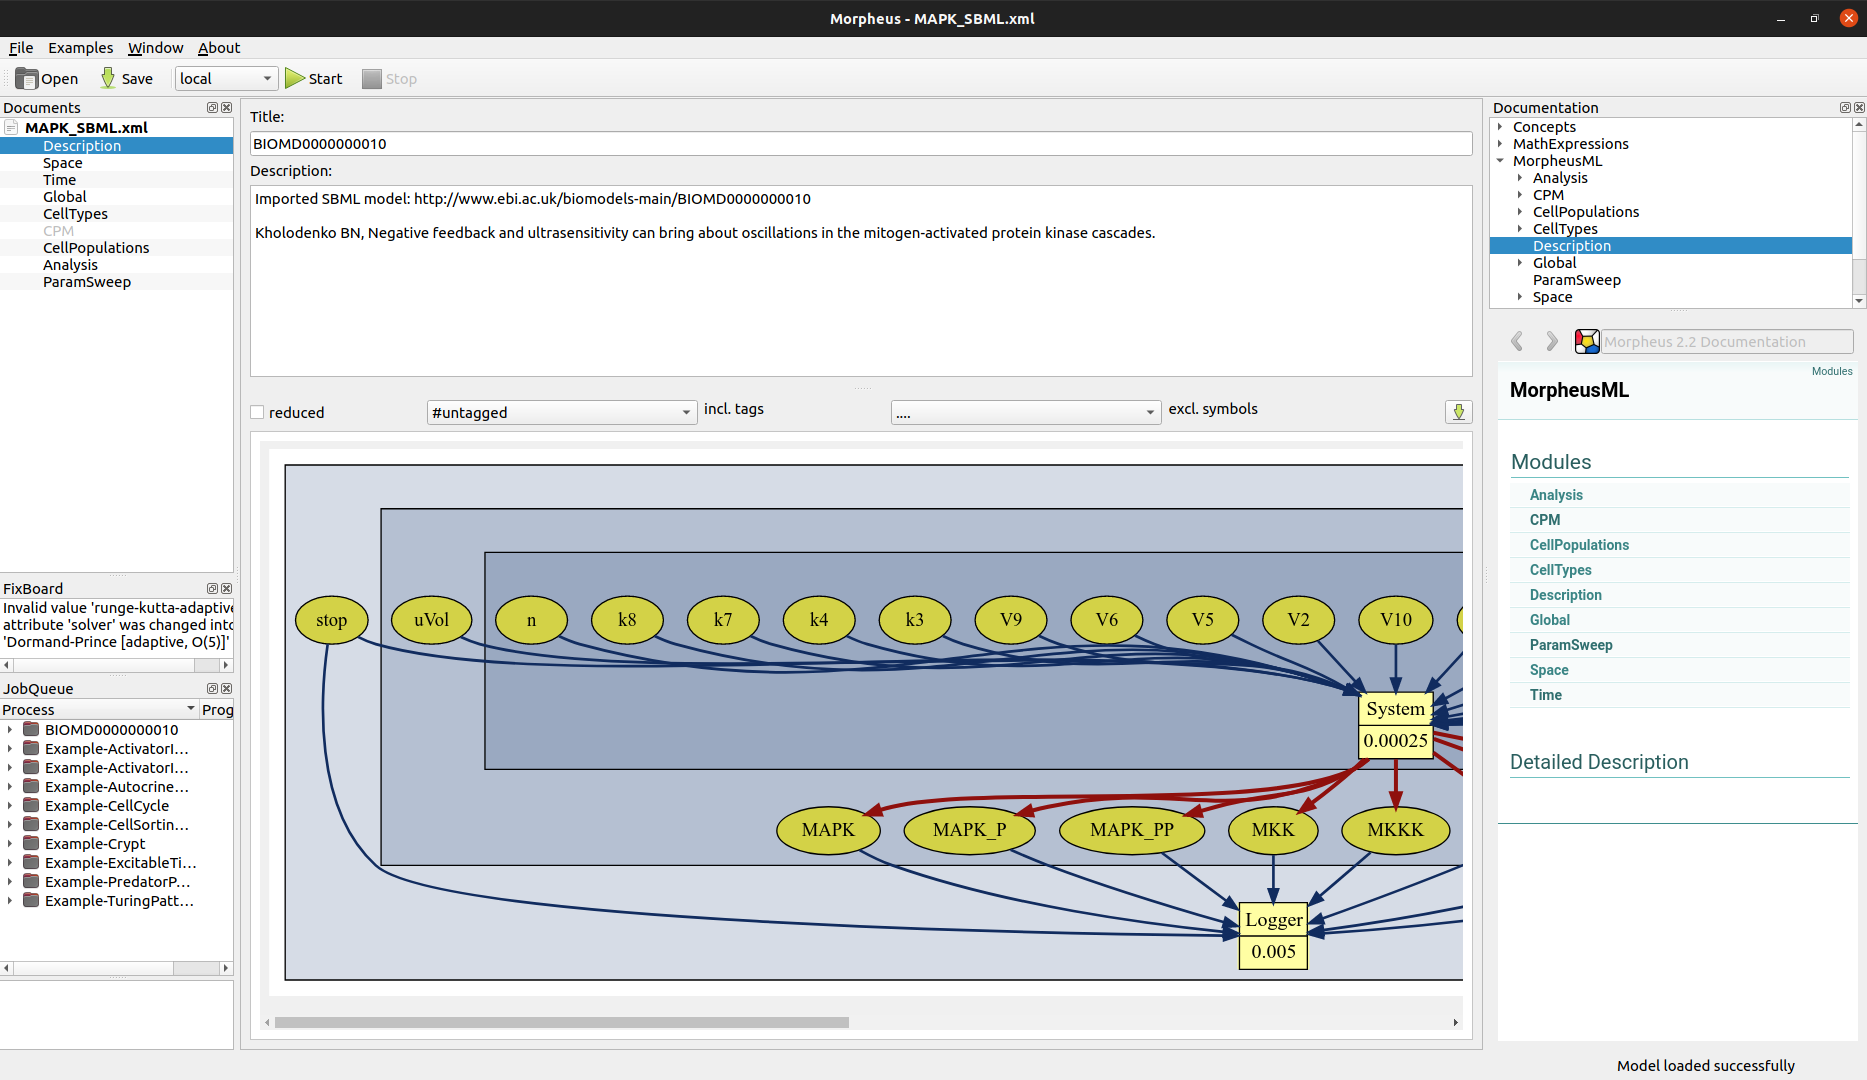

In [3]:
# model file
model_file = os.path.join("models", "MAPK_SBML.xml")

# run morpheus
# !morpheus-gui --url=$model_file

# display gui
from IPython.display import Image
Image("_static/morpheus_gui.png", width=800)

Assuming various of the model parameters to be unknown, we intend to infer them from observed data via pyABC.
Therefore, we specify the mapping of parameter ids to [XPaths](https://en.wikipedia.org/wiki/XPath) in the model file. XPaths of model entities can be easily obtained via the Morpheus GUI "Copy XPath" context menu.

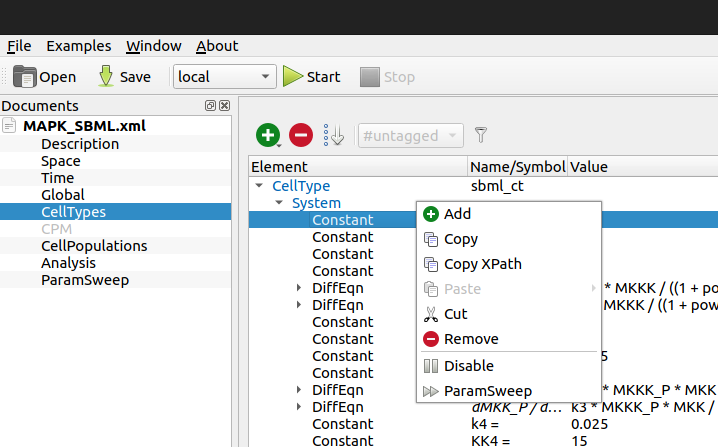

In [4]:
Image("_static/morpheus_xpath.png", width=400)

In [5]:
# parameter mapping
par_map = {
    "V1": "./CellTypes/CellType/System/Constant[@symbol='V1']",
    "V2": "./CellTypes/CellType/System/Constant[@symbol='V2']",
    "k3": "./CellTypes/CellType/System/Constant[@symbol='k3']",
}

# Morpheus model
model = fmc.model.MorpheusModel(
    model_file=model_file,
    par_map=par_map,
    raise_on_error=False,
)
print(model)

MorpheusModel {
  name         : models/MAPK_SBML.xml
  par_map      : {'V1': "./CellTypes/CellType/System/Constant[@symbol='V1']", 'V2': "./CellTypes/CellType/System/Constant[@symbol='V2']", 'k3': "./CellTypes/CellType/System/Constant[@symbol='k3']"}
  sumstat      : None
  executable   : morpheus
}


A short check whether everything works, prior to the analysis, is usually useful.

In [6]:
model.sanity_check()

FitMultiCell.Model INFO: Sanity check successful


Let us generate some dummy observed data from synthetic ground-truth parameters `true_pars`.
The parameters we define here must correspond to Constants in the Morpheus XML file.

In [7]:
true_pars = {'V1': 2.7, 'V2': 0.25, 'k3': 0.025}
limits = {key: (0.5 * val, 2 * val) for key, val in true_pars.items()}

# generate data
observed_data = model.sample(true_pars)
print(observed_data.keys())

dict_keys(['time', 'cell.id', 'MAPK', 'MAPK_P', 'MAPK_PP', 'MKK', 'MKK_P', 'MKK_PP', 'MKKK', 'MKKK_P'])


As usual, we have to define a prior for our parameters.

In [8]:
prior = pyabc.Distribution(
    **{
        key: pyabc.RV("uniform", lb, ub - lb)
        for key, (lb, ub) in limits.items()
    }
)

Also, we have to define a distance which computes a scalar value quantifying the discrepancy of generated and observed data.
Note that also this step can be customized, e.g. for arbitrary summary statistics.
Here, we use a simple L1 distance between selected outputs.

In [9]:
def distance(val1, val2):
    d = np.sum(
        [
            np.sum(np.abs(val1[key] - val2[key]))
            for key in ['MAPK_P', 'MKK_P']
        ]
    )
    return d

## Running the ABC inference

Now, we are able to run our ABC analysis. See the pyABC documentation for configuration options, e.g. regarding parallelization, distances, thresholds, or proposal distributions.

In [10]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=100)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
abc.new(db_path, observed_data)

ABC.Sampler INFO: Parallelize sampling on 12 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2022-01-20 12:38:11>


In [11]:
history = abc.run(max_nr_populations=5)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.42432419e+04.
ABC INFO: Accepted: 100 / 186 = 5.3763e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 1.14215269e+04.
ABC INFO: Accepted: 100 / 235 = 4.2553e-01, ESS: 7.9988e+01.
ABC INFO: t: 2, eps: 8.96405597e+03.
ABC INFO: Accepted: 100 / 237 = 4.2194e-01, ESS: 8.9190e+01.
ABC INFO: t: 3, eps: 6.12055219e+03.
ABC INFO: Accepted: 100 / 178 = 5.6180e-01, ESS: 8.2634e+01.
ABC INFO: t: 4, eps: 4.79957563e+03.
ABC INFO: Accepted: 100 / 199 = 5.0251e-01, ESS: 8.6064e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:40.425872, end_time=2022-01-20 12:38:51>


## Visualization and analysis

The `history` file contains the analysis results. We can use pyABC's visualization routines to analyse the result.

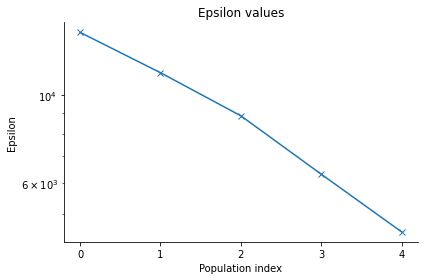

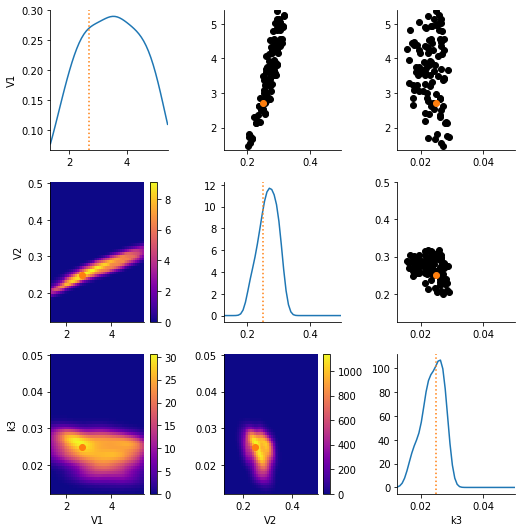

In [12]:
pyabc.visualization.plot_epsilons(history)
pyabc.visualization.plot_kde_matrix_highlevel(history, limits=limits, refval=true_pars);